In [3]:
import numpy as np
import sys
import modisco.visualization
from modisco.visualization import viz_sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

def one_hot_encode_along_channel_axis(sequence):
  to_return = np.zeros((len(sequence),4), dtype=np.int8)
  seq_to_one_hot_fill_in_array(zeros_array=to_return,
                               sequence=sequence, one_hot_axis=1)
  return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
  assert one_hot_axis==0 or one_hot_axis==1
  if (one_hot_axis==0):
      assert zeros_array.shape[1] == len(sequence)
  elif (one_hot_axis==1):
      assert zeros_array.shape[0] == len(sequence)
  #will mutate zeros_array
  for (i,char) in enumerate(sequence):
    if (char=="A" or char=="a"):
      char_idx = 0
    elif (char=="C" or char=="c"):
      char_idx = 1
    elif (char=="G" or char=="g"):
      char_idx = 2
    elif (char=="T" or char=="t"):
      char_idx = 3
    elif (char=="N" or char=="n"):
      continue #leave that pos as all 0's
    else:
      raise RuntimeError("Unsupported character: "+str(char))
    if (one_hot_axis==0):
      zeros_array[char_idx,i] = 1
    elif (one_hot_axis==1):
      zeros_array[i,char_idx] = 1

def normalize_scores(impscores, hyp_impscores, onehotData):
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
    imp_score_each_pos = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_pos = np.sign(imp_score_each_pos)
    hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                 *imp_score_sign_each_pos[:,None] > 0)
    hyp_scores_same_sign_imp_scores_sum = np.sum(
        hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
    norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
    norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
    normed_hyp_impscores.append(norm_hyp)
    normed_impscores.append(norm_hyp*onehotData[i])
  return np.array(normed_impscores), np.array(normed_hyp_impscores)

In [4]:
import math, os
os.chdir('/projects/pfenninggroup/machineLearningForComputationalBiology/retina/scripts/zoonomia')

impFile = "shap/neighbor_accelerated.pos16.imp_SHAP_scores.txt"
hypFile = "shap/neighbor_accelerated.pos16.hyp_SHAP_scores.txt"
fastaFile = "shap/neighbor_accelerated.pos16.fasta"
# impFile = "shap/accelerated2.pos21.imp_SHAP_scores.txt"
# hypFile = "shap/accelerated2.pos21.hyp_SHAP_scores.txt"
# fastaFile = "shap/accelerated2.pos21.fasta"
#impFile = "shap/multispecies.pos2000.imp_SHAP_scores.txt"
#hypFile = "shap/multispecies.pos2000.hyp_SHAP_scores.txt"
#fastaFile = "shap/multispecies.pos2000.fasta"

print("reading imp scores...")
impscores = np.array([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(impFile)
])
print("reading hyp imp scores...")
hyp_impscores = np.array([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(hypFile)
])
print("reading fasta...")
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fastaFile))
              if i%2==1]
print("encoding data...")
onehotData = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])
print("normalizing scores...")
norm_impscores, norm_hyp_impscores = normalize_scores(impscores, hyp_impscores, onehotData)
for i in range(len(norm_impscores)):
    for j in range(len(norm_impscores[0])):
        for k in range(len(norm_impscores[0][0])):
            if math.isnan(norm_impscores[i][j][k]):
                norm_impscores[i][j][k] = 0.0
            elif math.isnan(norm_hyp_impscores[i][j][k]):
                norm_hyp_impscores[i][j][k] = 0.0

reading imp scores...
reading hyp imp scores...
reading fasta...
encoding data...
normalizing scores...


/home/csriniv1/anaconda2/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


In [5]:
from modisco.visualization.viz_sequence import *

#ymin, ymax = (np.max(norm_impscores), np.min(norm_impscores))
#print(ymin, ymax)
ymin, ymax = (0.029544496908783913, -0.019507570192217827)


def plot_weights_given_ax2(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)
    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    #ax.set_ylim(ymax, ymin)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)
    return ax


def plot_weights2(array,
                 figsize=(20,2),
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax = plot_weights_given_ax2(ax=ax, array=array,**kwargs)
    return fig, ax

15
10
2
3
13
11
0
6
9
8
12
4
1
14
7
5


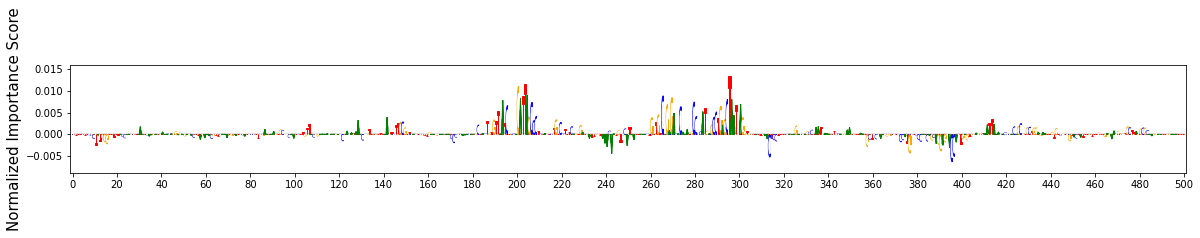

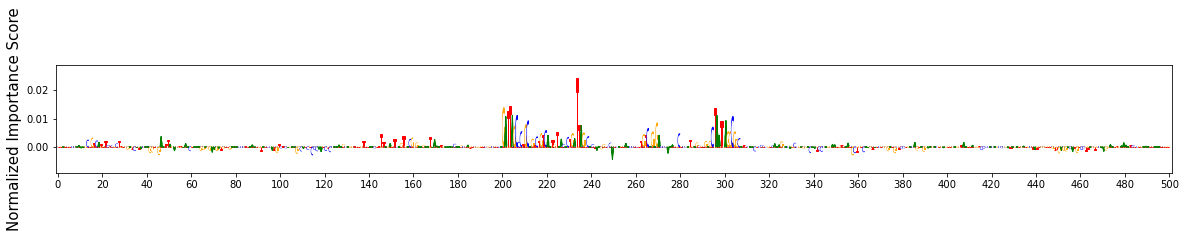

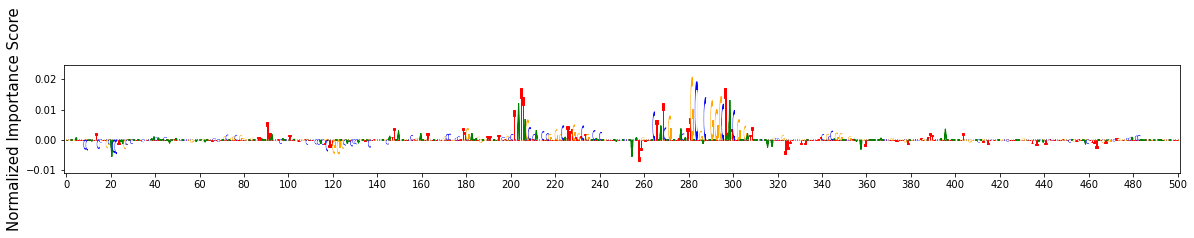

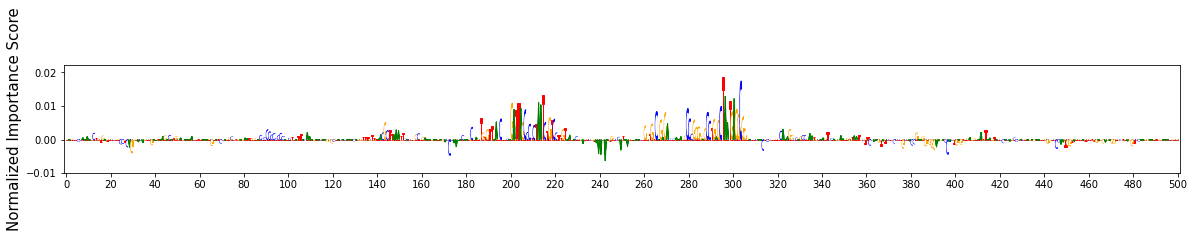

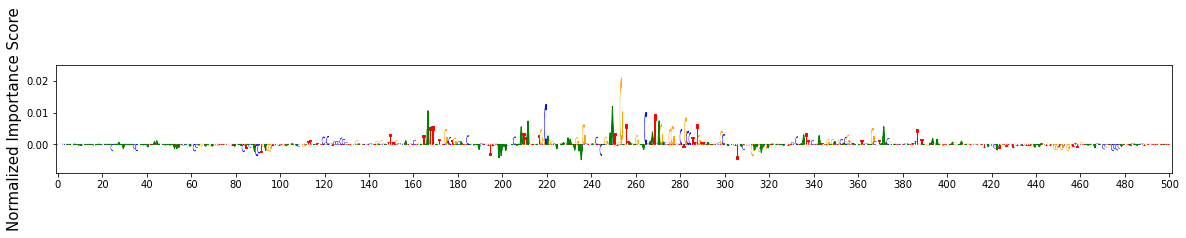

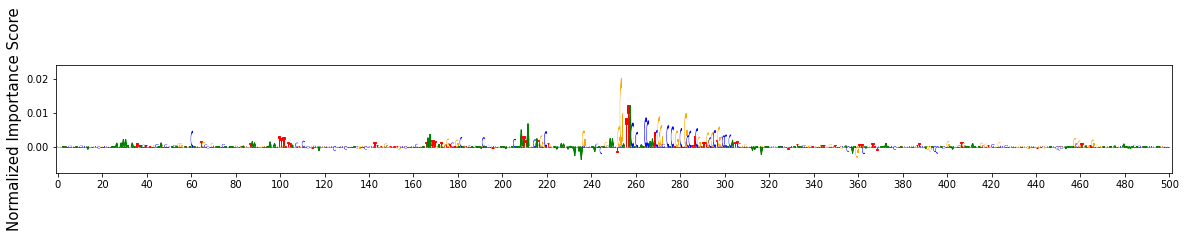

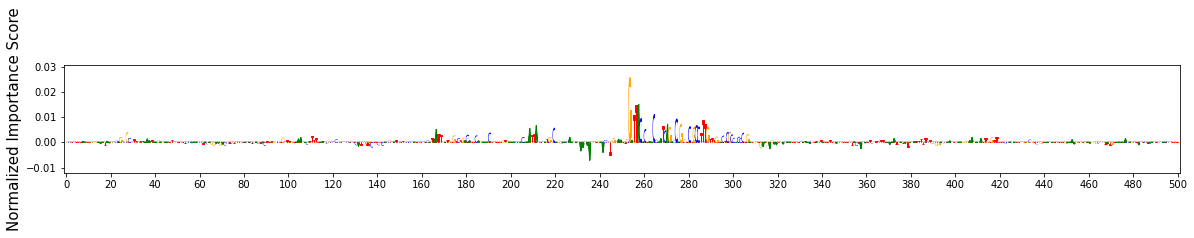

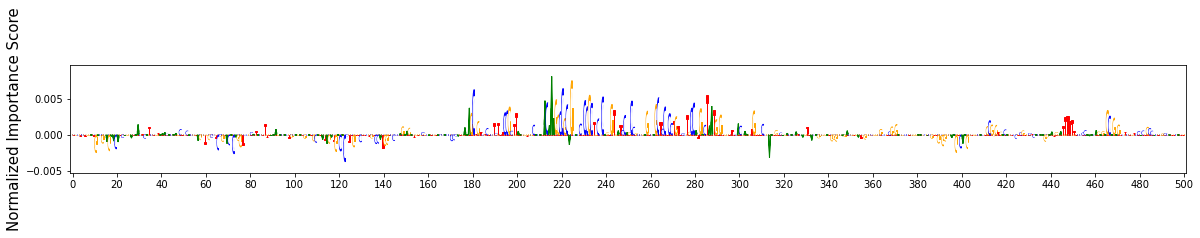

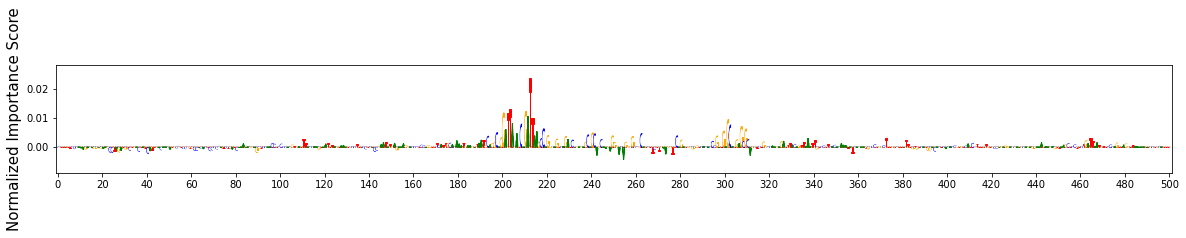

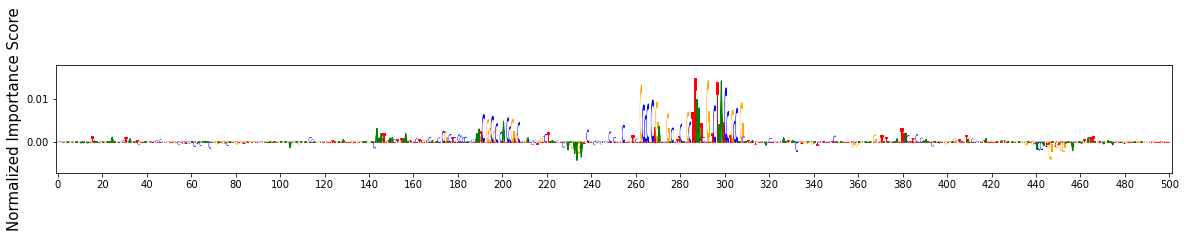

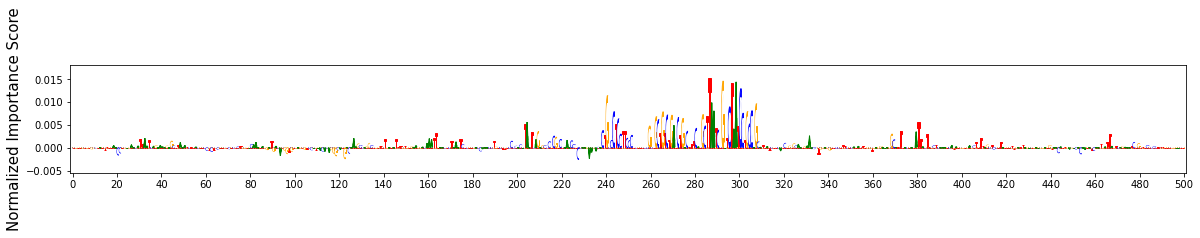

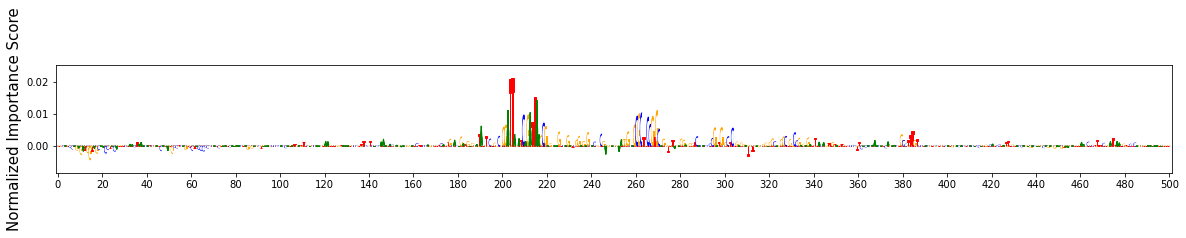

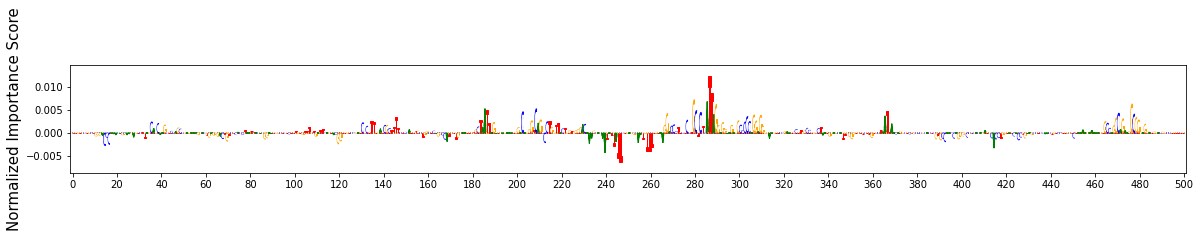

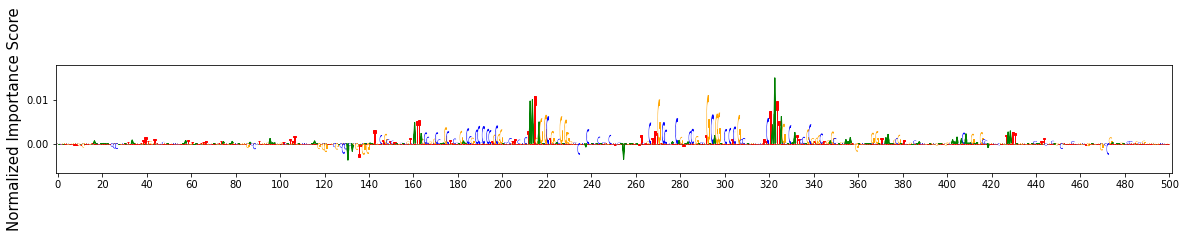

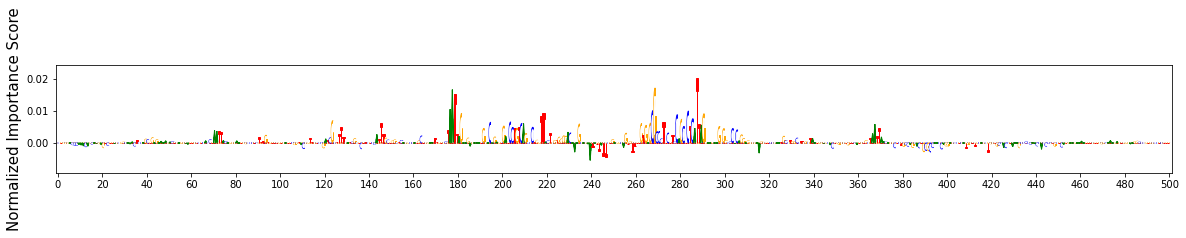

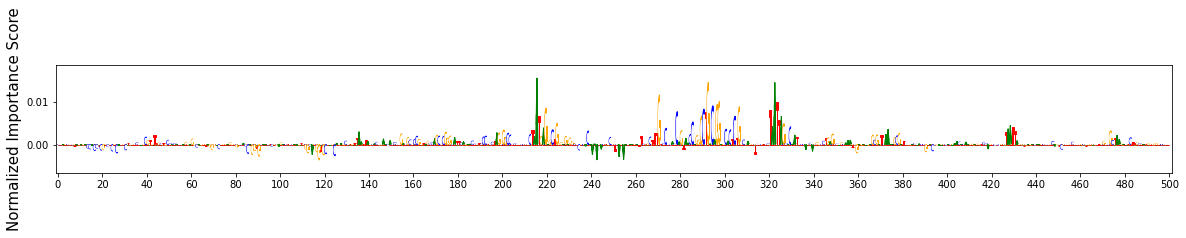

In [9]:
import sys

peak_to_tf = {"13618":"BMP4", "13719":"OTX2", "2334":"PAX6", "21608":"SIX3", "14161":"VSX2"}
peaklist = np.loadtxt(fastaFile, dtype=str)[::2]
peaklist = [peak_to_tf[x.split(">peak")[1].split(":")[0]] for x in peaklist]
species = ["Chrysochloris_asiatica", "Condylura_cristata", "Heterocephalus_glaber", 
           "Homo_sapiens", "Mus_musculus", "Nannospalax_galili"]
#species = ["Condylura_cristata", "Homo_sapiens", "Chrysochloris_asiatica", "Homo_sapiens", 
#            "Heterocephalus_glaber", "Mus_musculus", "Heterocephalus_glaber", "Nannospalax_galili", 
#            "Condylura_cristata", "Mus_musculus", "Heterocephalus_glaber", "Mus_musculus", "Homo_sapiens", 
#            "Nannospalax_galili", "Heterocephalus_glaber", "Nannospalax_galili", "Condylura_cristata", 
#            "Condylura_cristata", "Homo_sapiens", "Nannospalax_galili", "Mus_musculus"]
species = ["Equus_asinus", "Cricetomys_gambianus", "Equus_asinus", "Petromus_typicus", "Petromus_typicus",
          "Petromus_typicus", "Petromus_typicus", "Equus_asinus", "Echinops_telfairi", "Cricetomys_gambianus",
          "Echinops_telfairi", "Echinops_telfairi", "Equus_asinus", "Cricetomys_gambianus", "Echinops_telfairi",
          "Cricetomys_gambianus"]

names = list()
for i in range(len(species)):
  names.append(peaklist[i] + "_" + species[i])
sort_dict = {names[i] : i for i in range(len(names))}
idx_order = [sort_dict[name] for name in sorted(names)]

for i in idx_order:
  print(i)
  fig, ax = plot_weights2(norm_impscores[i], subticks_frequency=20, ylabel="Normalized Importance Score")

  #viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=20)
  #fig.savefig("../../plots/modisco/"+ names[i] + ".png", dpi=300)
  #fig.savefig("../../plots/modisco/"+ names[i] + ".svg", format='svg', dpi=300)

In [5]:
print("done")

done


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


os.chdir('/home/csriniv1/')

fastaFile = "/projects/pfenninggroup/machineLearningForComputationalBiology/retina/scripts/zoonomia/shap/multispecies.pos2000.fasta"
hdf5_results = h5py.File("/projects/pfenninggroup/machineLearningForComputationalBiology/retina/scripts/zoonomia/results/multispecies_tfmodiscoResults.hdf5","r")
print(hdf5_results)
print("Metaclusters heatmap")

activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

print("reading fasta...")
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fastaFile))
              if i%2==1]
print("encoding data...")
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))
i = 0

        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        fig, ax = plot_weights2(pattern["task0_hypothetical_contribs"]["fwd"], subticks_frequency=20)
        fig.savefig("modisco_output/"+str(i)+".svg", format="svg", dpi=300)
        i += 1

IndentationError: unexpected indent (<ipython-input-4-92998476cf91>, line 38)

     |████████████████████████████████| 49.9 MB 5.0 MB/s eta 0:00:01    |███▌                            | 5.4 MB 5.0 MB/s eta 0:00:09     |█████████████████████████▌      | 39.8 MB 5.0 MB/s eta 0:00:03


TypeError: unhashable type: 'numpy.ndarray'

Metaclusters heatmap


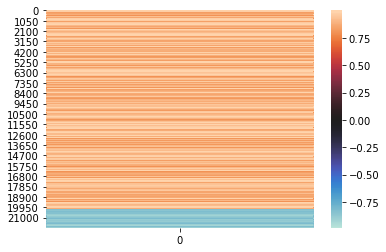

In [6]:
import h5py
import modisco.util


from collections import Counter
from modisco.visualization import viz_sequence

from matplotlib import pyplot as plt

import modisco.affinitymat.core

import modisco.cluster.phenograph.core

import modisco.cluster.phenograph.cluster

import modisco.cluster.core

import modisco.aggregator
import numpy as np


hdf5_results = h5py.File("/projects/pfenninggroup/machineLearningForComputationalBiology/retina/scripts/zoonomia/results/multispecies_tfmodiscoResults.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_0
activity pattern: [1]
22
metacluster_0 pattern_0
total seqlets: 986
Task 0 hypothetical scores:


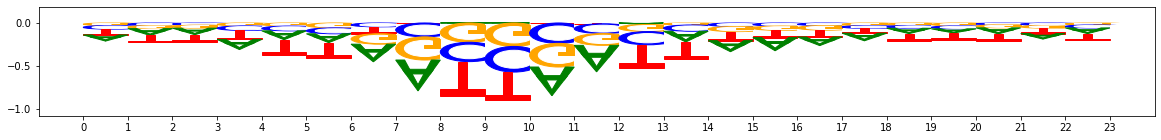

Task 0 actual importance scores:


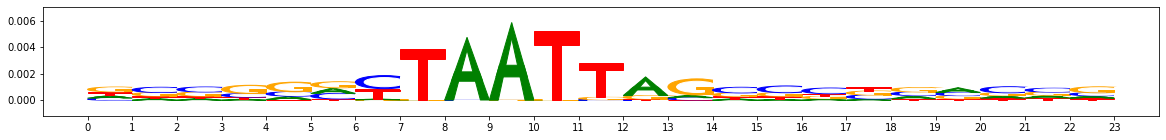

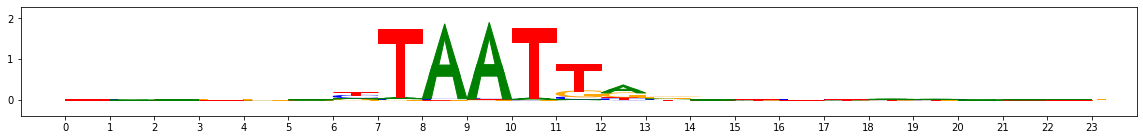

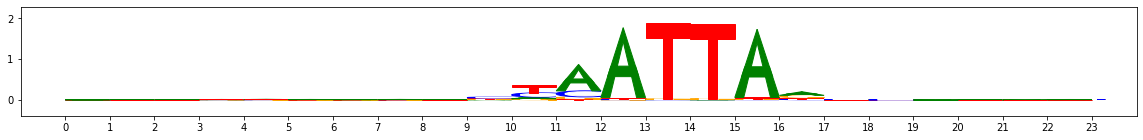

metacluster_0 pattern_1
total seqlets: 806
Task 0 hypothetical scores:


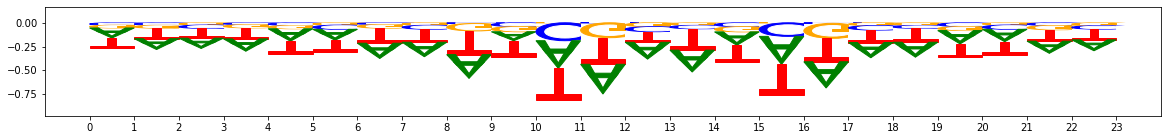

Task 0 actual importance scores:


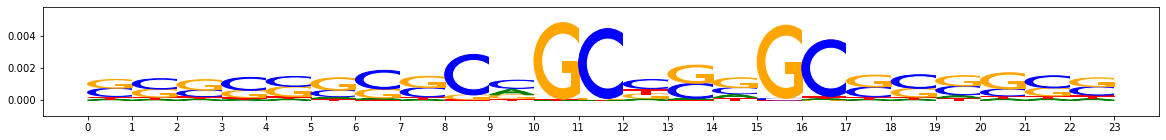

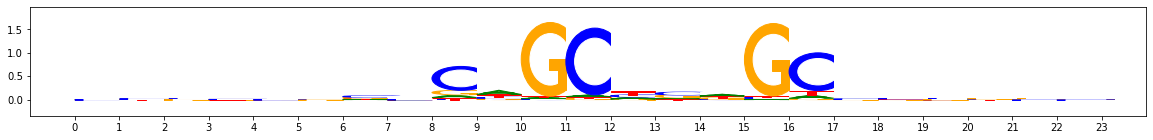

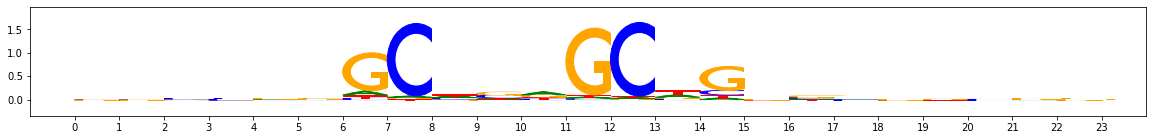

metacluster_0 pattern_2
total seqlets: 760
Task 0 hypothetical scores:


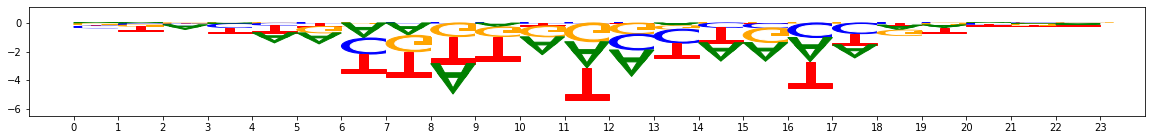

Task 0 actual importance scores:


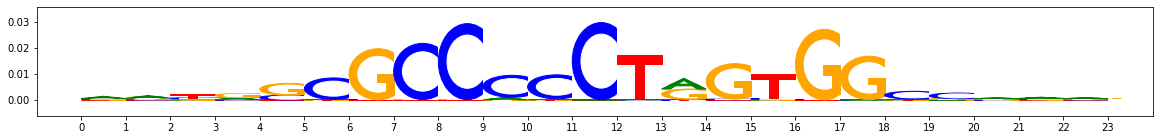

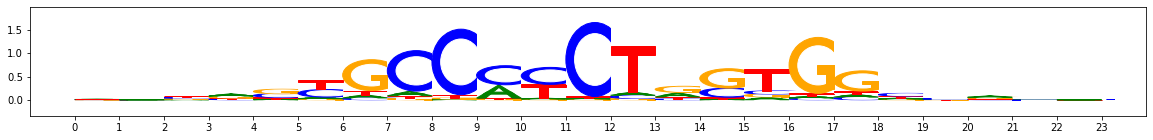

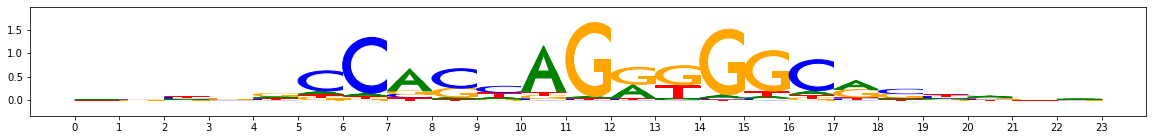

metacluster_0 pattern_3
total seqlets: 749
Task 0 hypothetical scores:


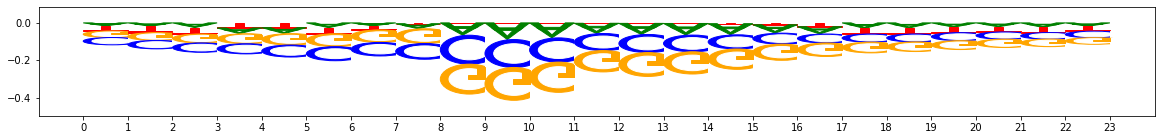

Task 0 actual importance scores:


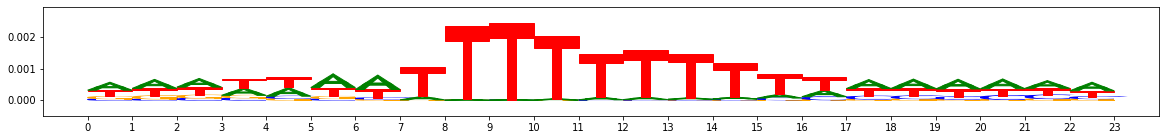

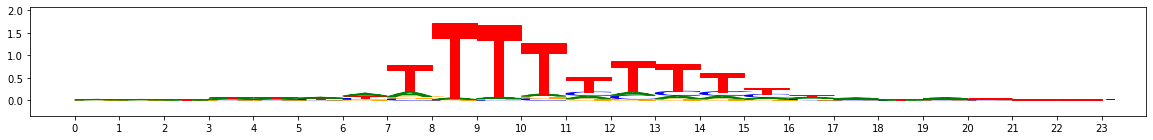

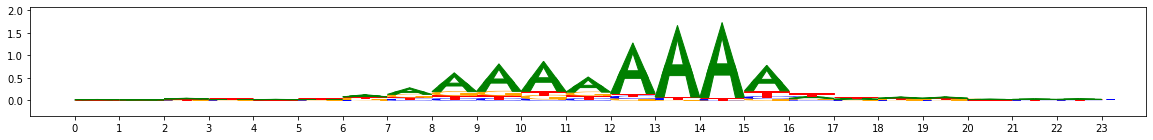

metacluster_0 pattern_4
total seqlets: 534
Task 0 hypothetical scores:


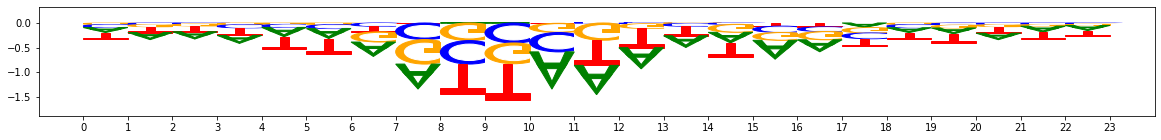

Task 0 actual importance scores:


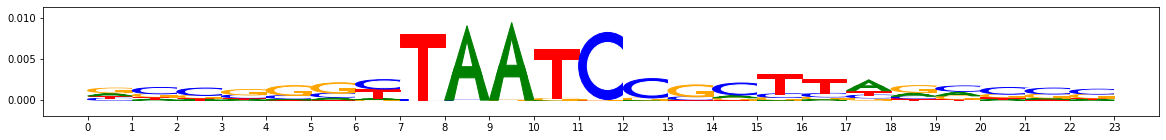

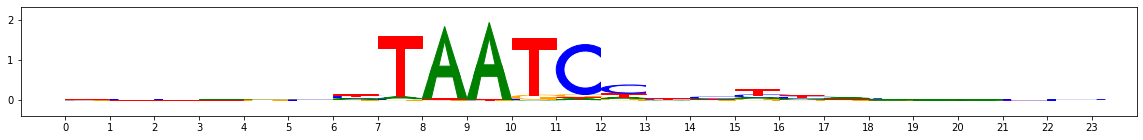

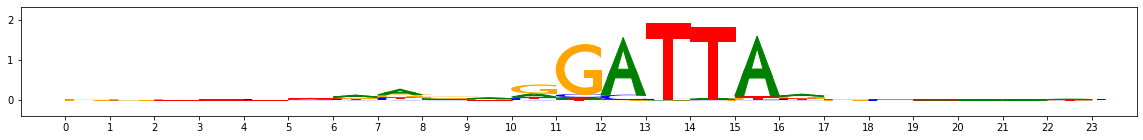

metacluster_0 pattern_5
total seqlets: 390
Task 0 hypothetical scores:


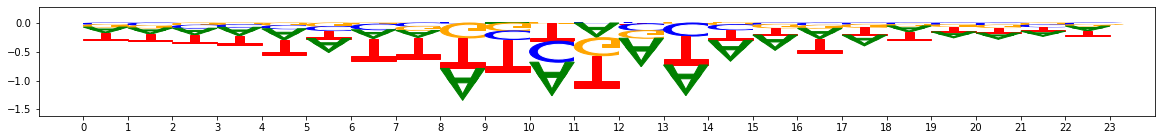

Task 0 actual importance scores:


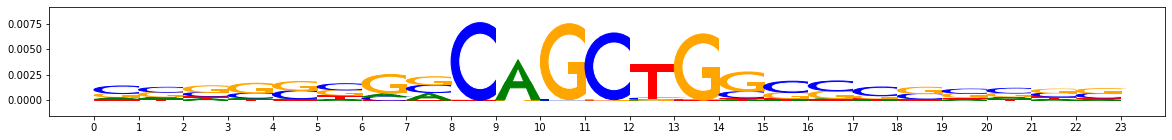

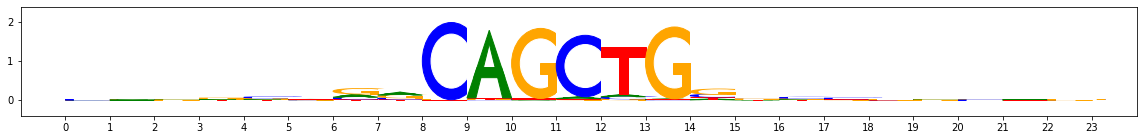

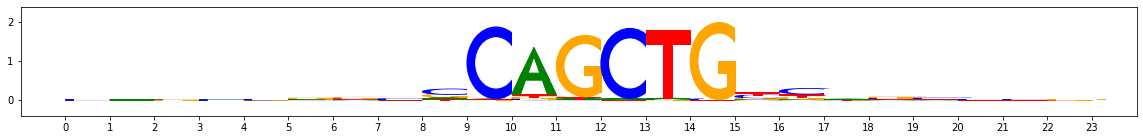

metacluster_0 pattern_6
total seqlets: 367
Task 0 hypothetical scores:


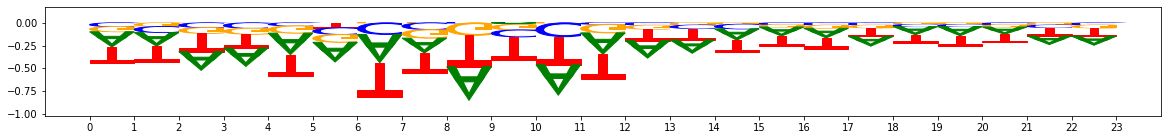

Task 0 actual importance scores:


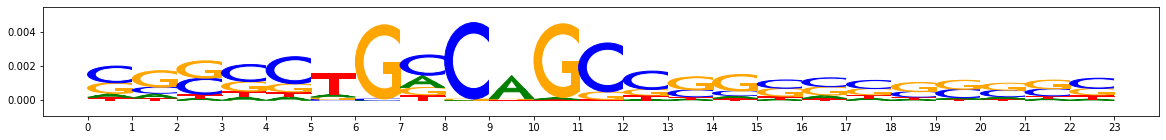

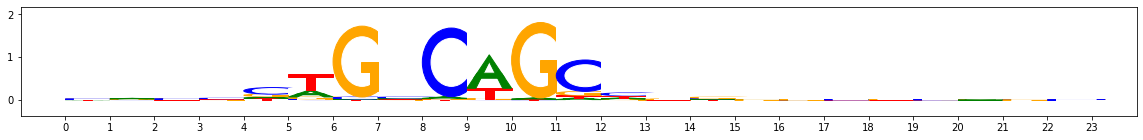

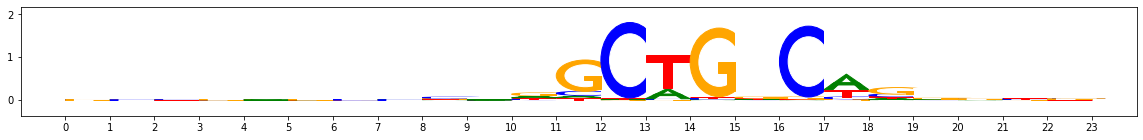

metacluster_0 pattern_7
total seqlets: 367
Task 0 hypothetical scores:


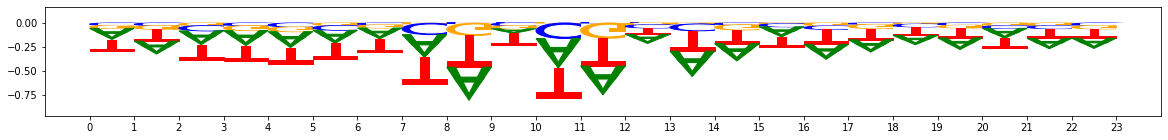

Task 0 actual importance scores:


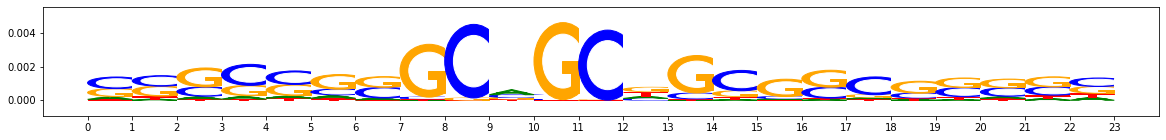

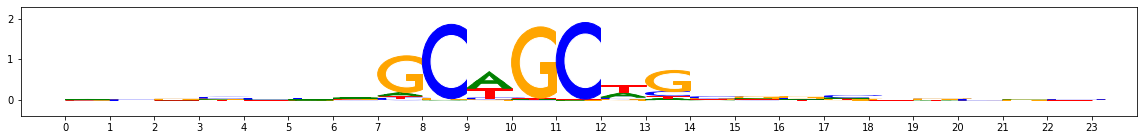

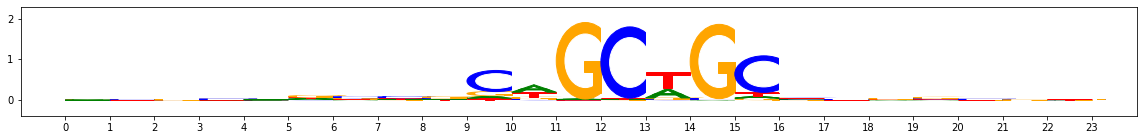

metacluster_0 pattern_8
total seqlets: 331
Task 0 hypothetical scores:


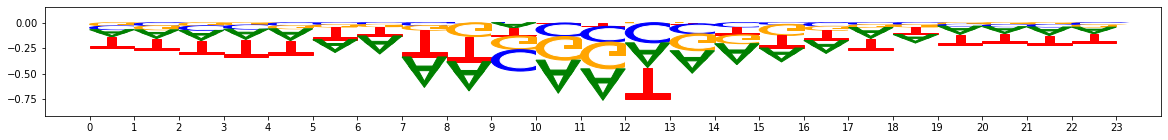

Task 0 actual importance scores:


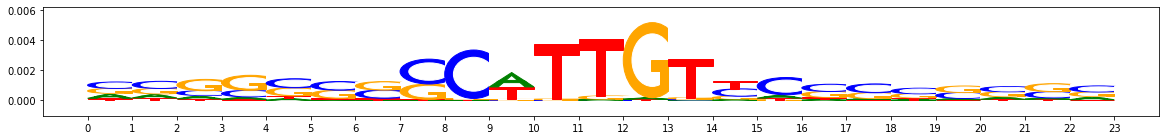

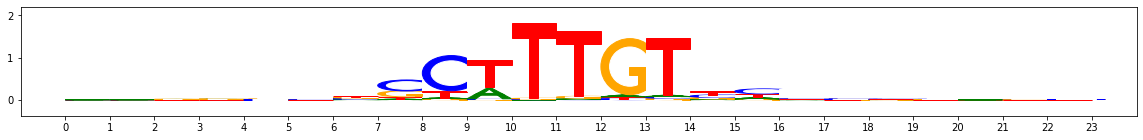

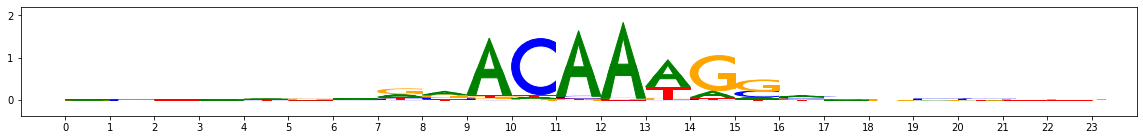

metacluster_0 pattern_9
total seqlets: 315
Task 0 hypothetical scores:


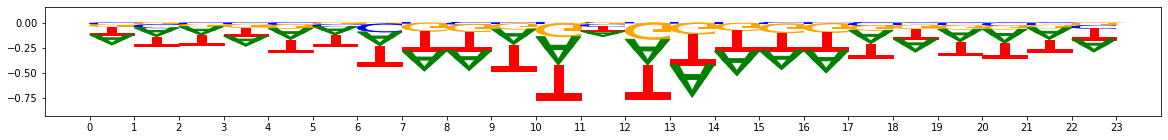

Task 0 actual importance scores:


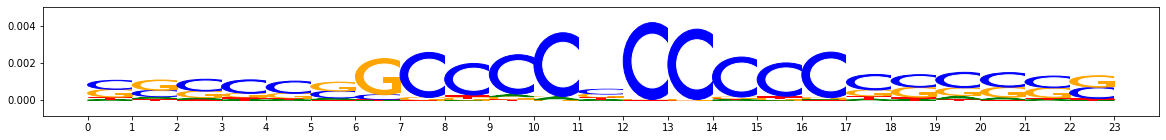

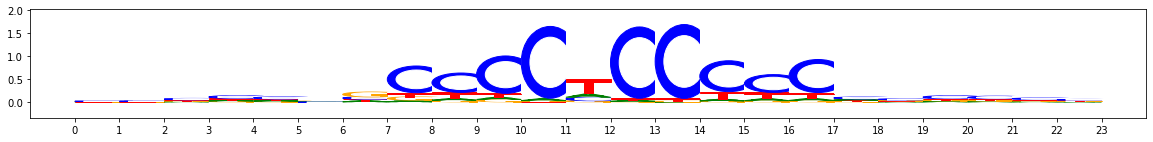

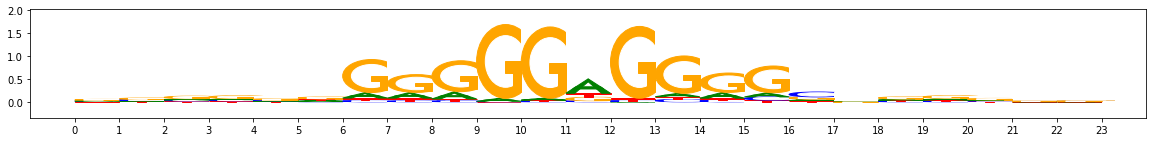

metacluster_0 pattern_10
total seqlets: 265
Task 0 hypothetical scores:


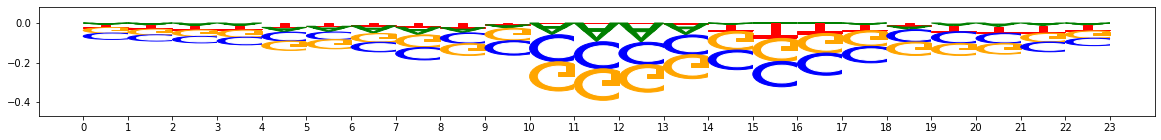

Task 0 actual importance scores:


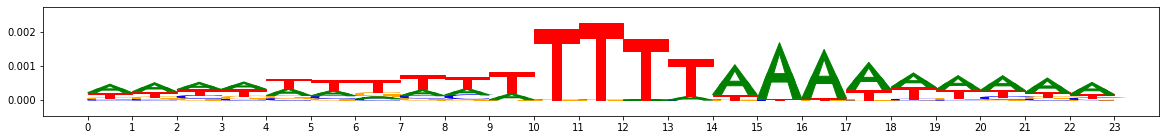

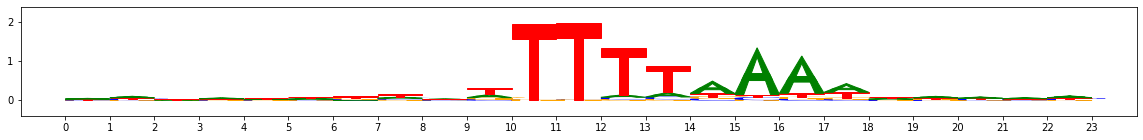

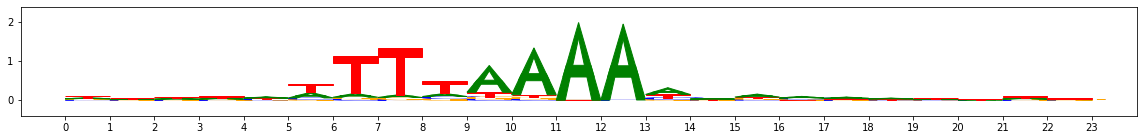

metacluster_0 pattern_11
total seqlets: 263
Task 0 hypothetical scores:


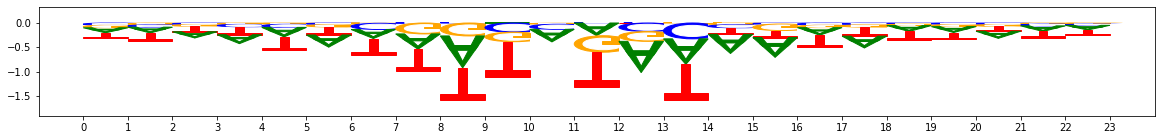

Task 0 actual importance scores:


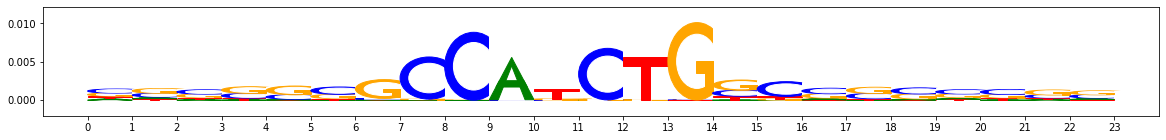

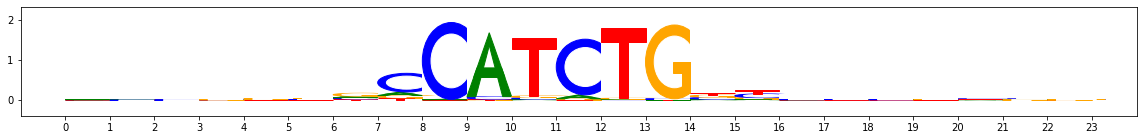

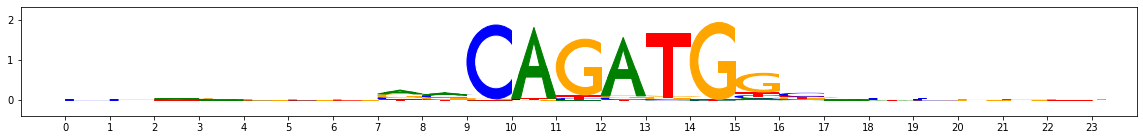

metacluster_0 pattern_12
total seqlets: 254
Task 0 hypothetical scores:


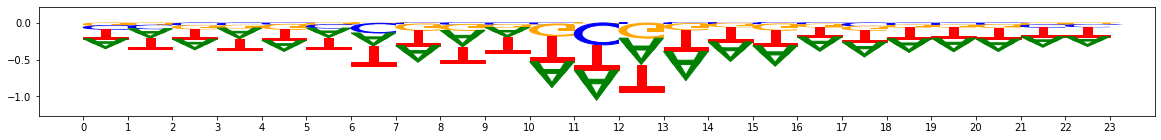

Task 0 actual importance scores:


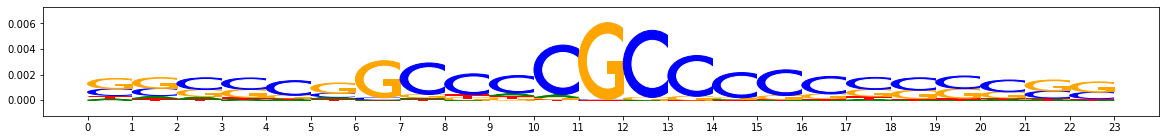

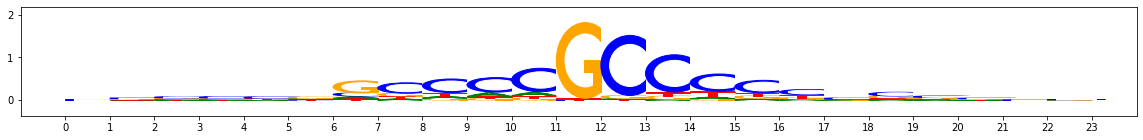

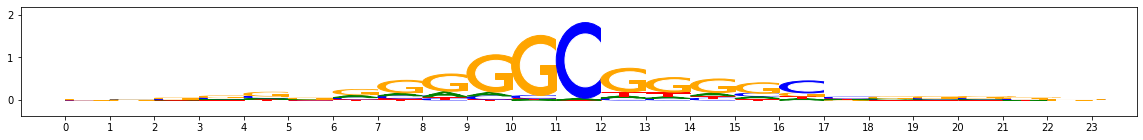

metacluster_0 pattern_13
total seqlets: 253
Task 0 hypothetical scores:


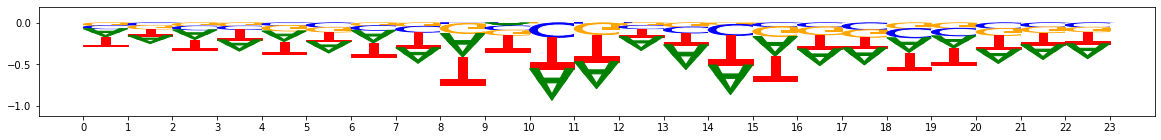

Task 0 actual importance scores:


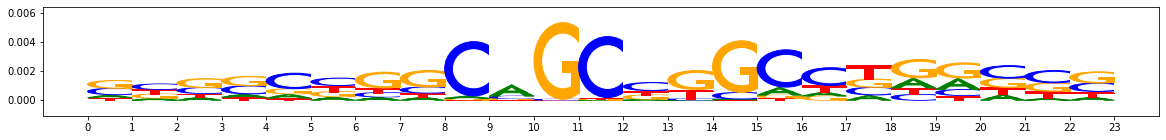

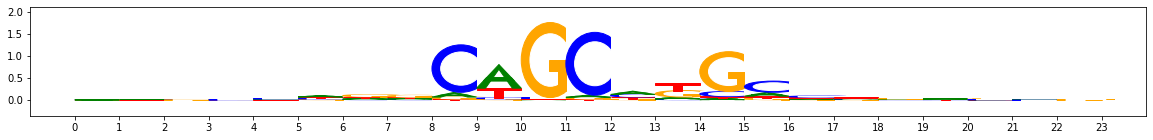

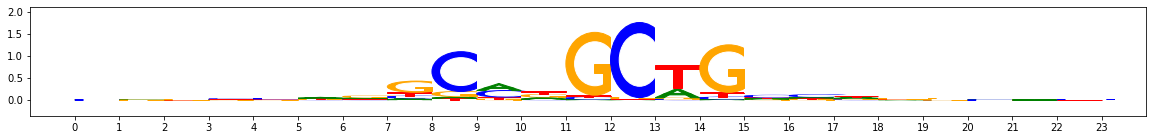

metacluster_0 pattern_14
total seqlets: 218
Task 0 hypothetical scores:


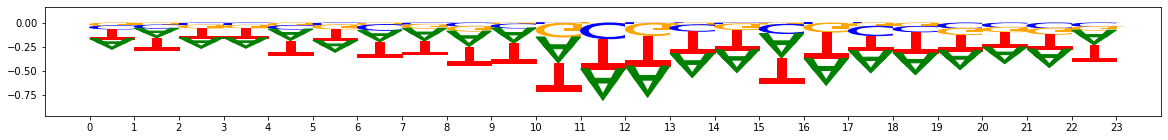

Task 0 actual importance scores:


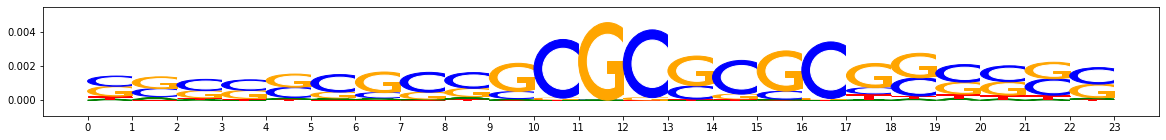

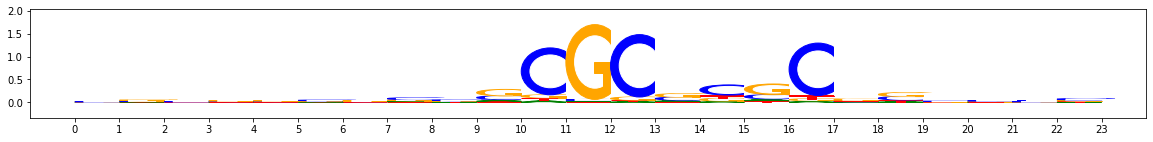

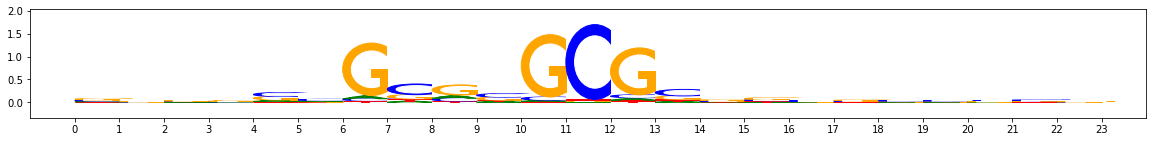

metacluster_0 pattern_15
total seqlets: 184
Task 0 hypothetical scores:


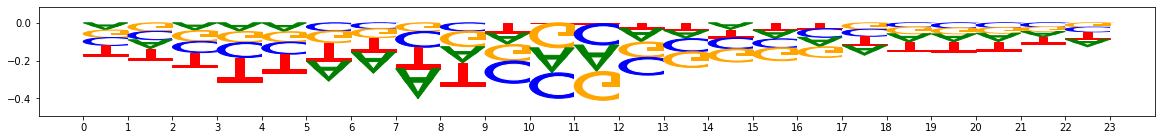

Task 0 actual importance scores:


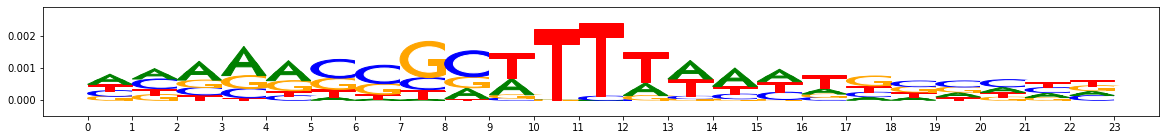

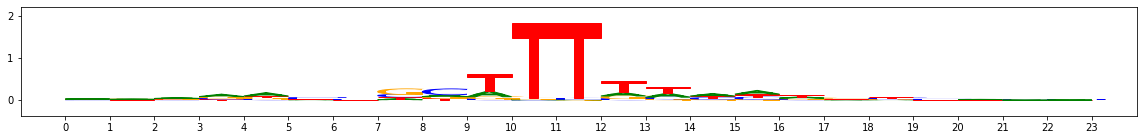

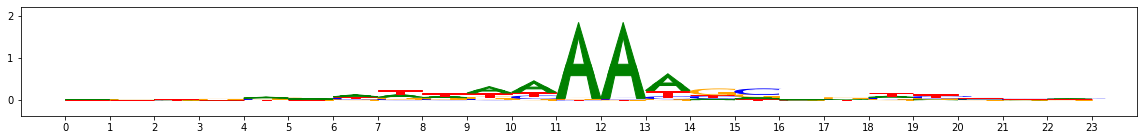

metacluster_0 pattern_16
total seqlets: 164
Task 0 hypothetical scores:


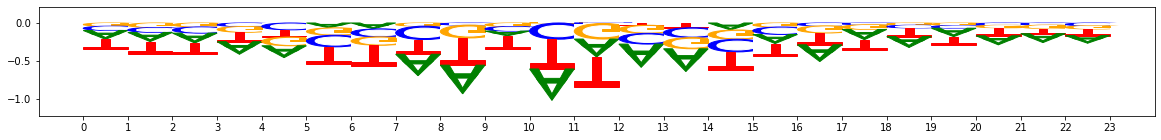

Task 0 actual importance scores:


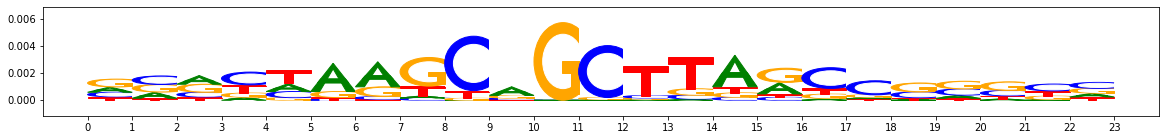

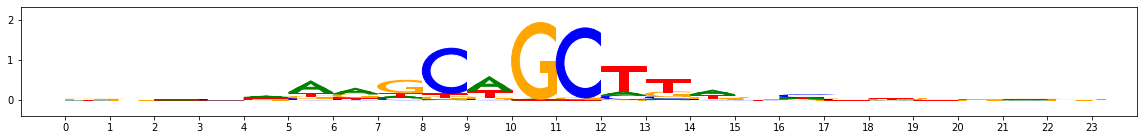

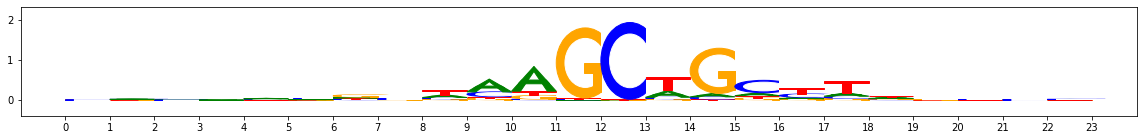

metacluster_0 pattern_17
total seqlets: 154
Task 0 hypothetical scores:


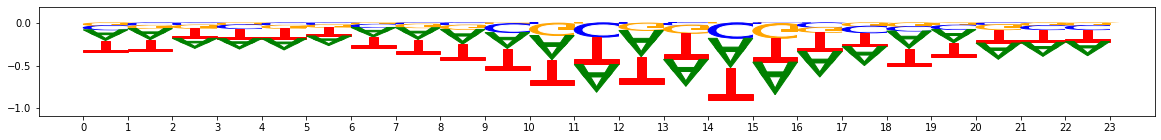

Task 0 actual importance scores:


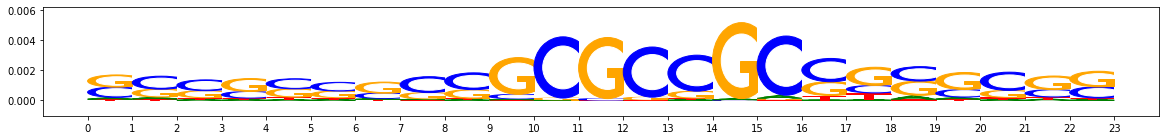

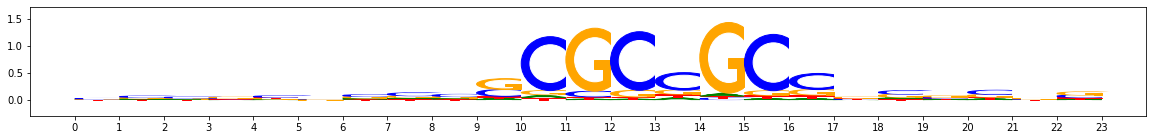

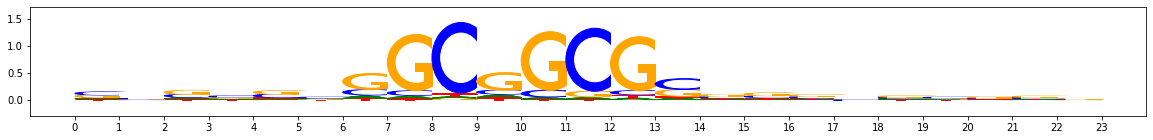

metacluster_0 pattern_18
total seqlets: 141
Task 0 hypothetical scores:


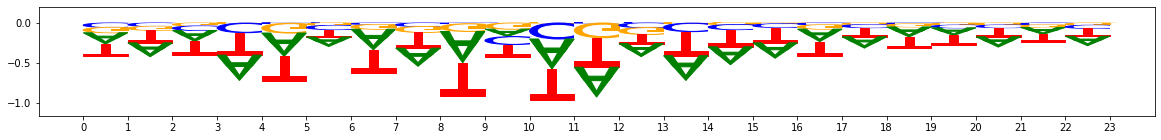

Task 0 actual importance scores:


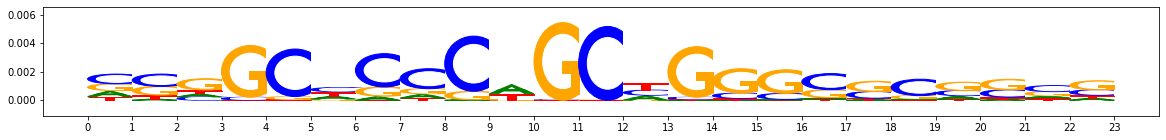

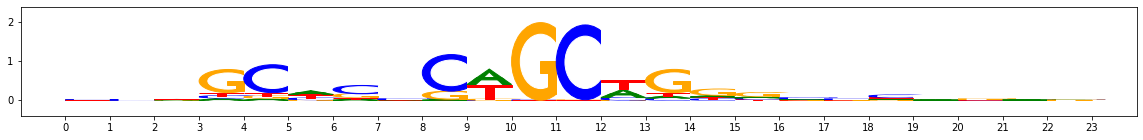

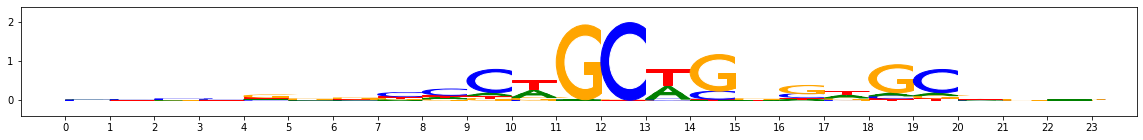

metacluster_0 pattern_19
total seqlets: 107
Task 0 hypothetical scores:


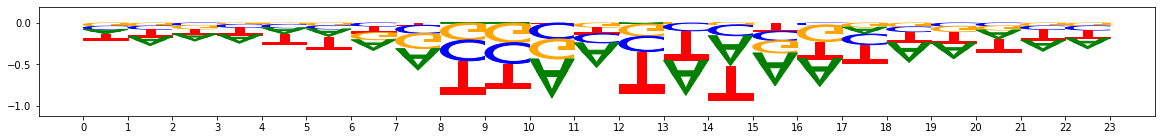

Task 0 actual importance scores:


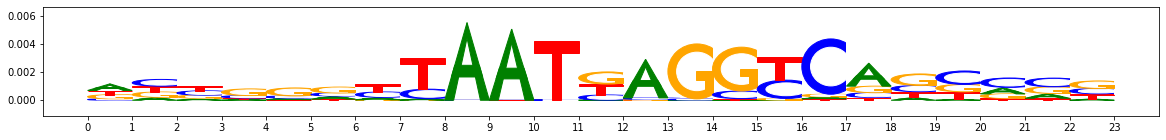

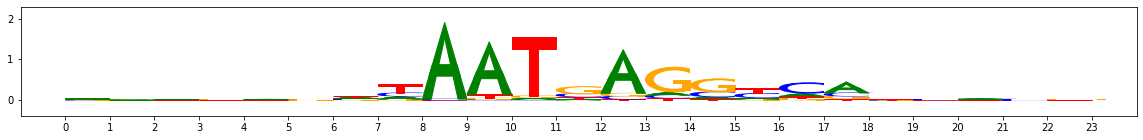

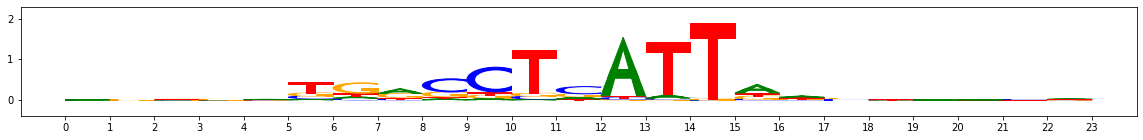

metacluster_0 pattern_20
total seqlets: 91
Task 0 hypothetical scores:


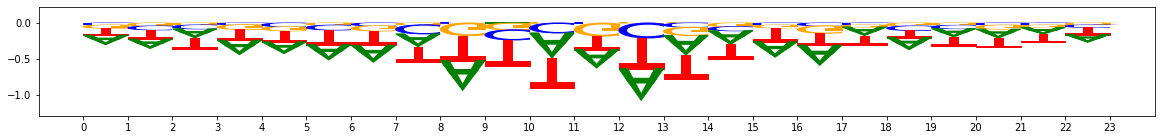

Task 0 actual importance scores:


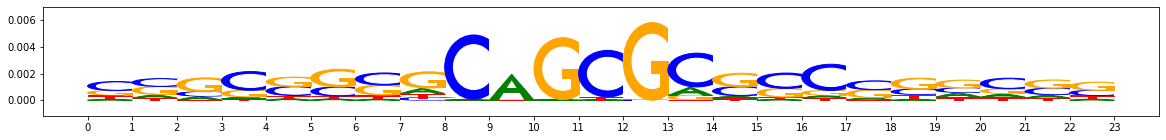

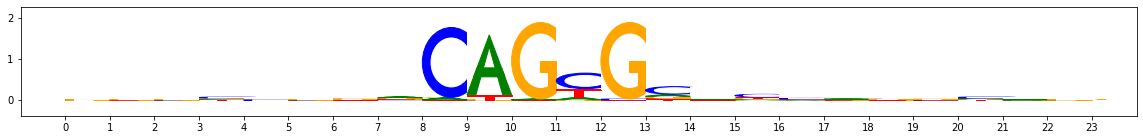

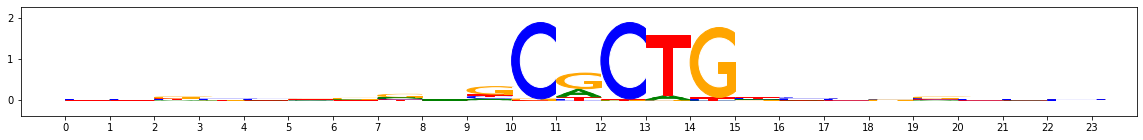

metacluster_0 pattern_21
total seqlets: 61
Task 0 hypothetical scores:


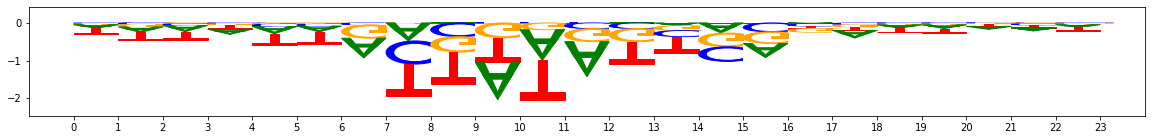

Task 0 actual importance scores:


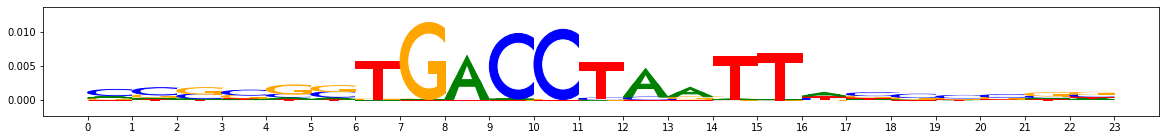

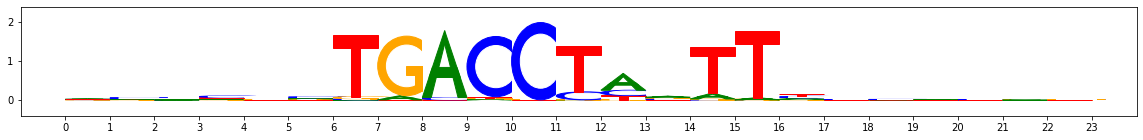

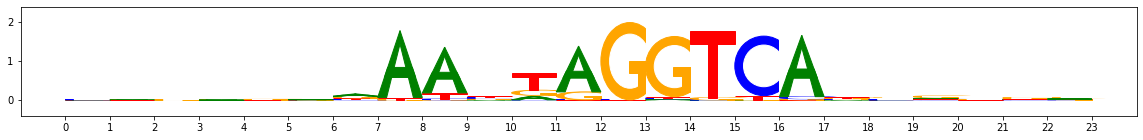

metacluster_1
activity pattern: [-1]
13
metacluster_1 pattern_0
total seqlets: 533
Task 0 hypothetical scores:


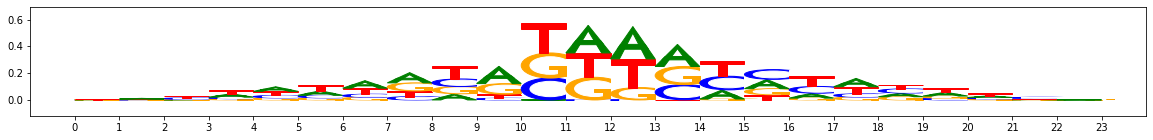

Task 0 actual importance scores:


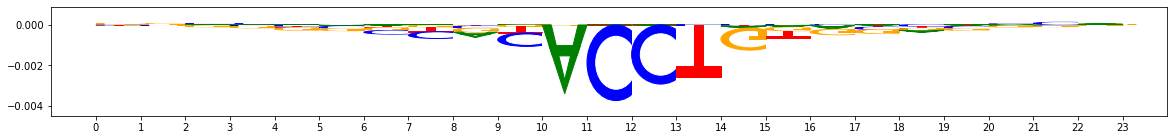

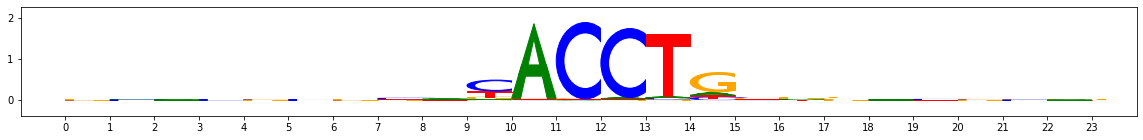

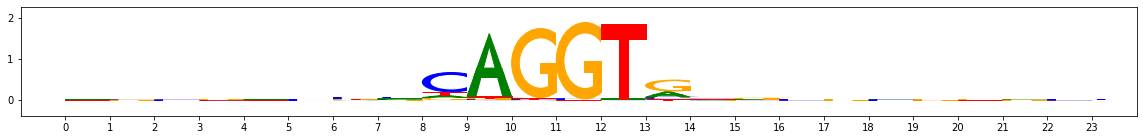

metacluster_1 pattern_1
total seqlets: 124
Task 0 hypothetical scores:


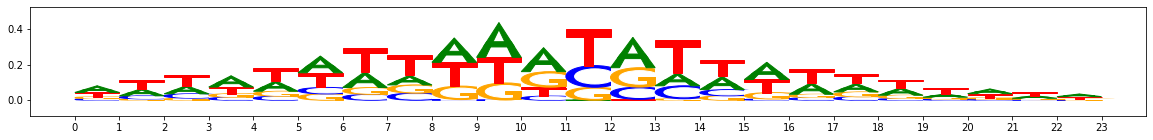

Task 0 actual importance scores:


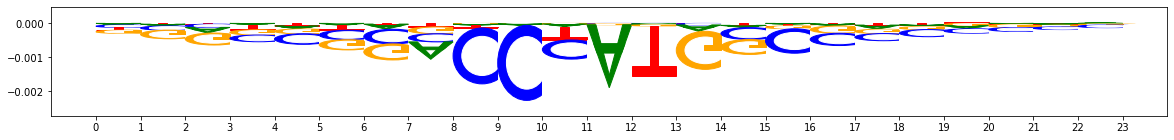

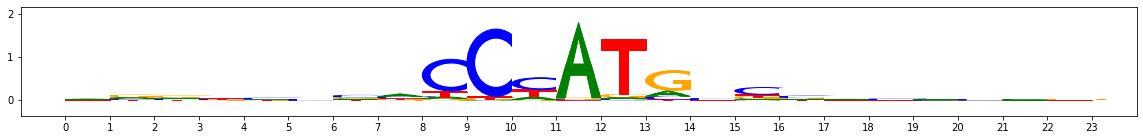

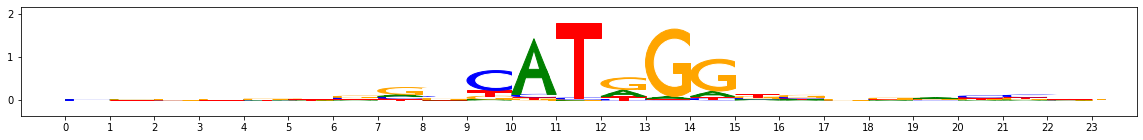

metacluster_1 pattern_2
total seqlets: 100
Task 0 hypothetical scores:


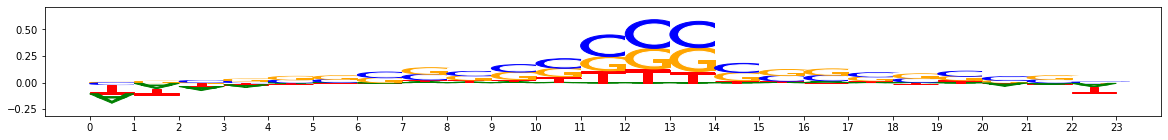

Task 0 actual importance scores:


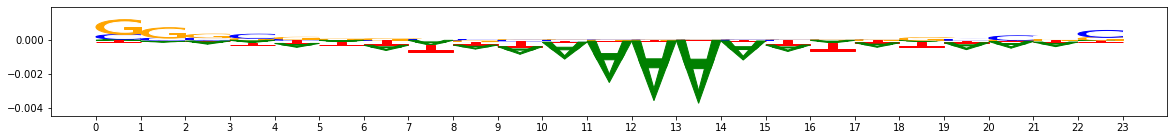

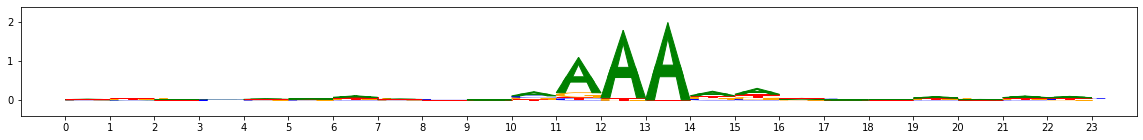

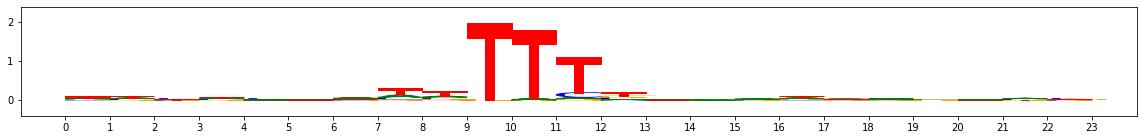

metacluster_1 pattern_3
total seqlets: 92
Task 0 hypothetical scores:


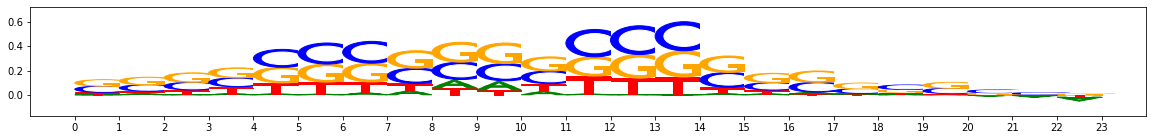

Task 0 actual importance scores:


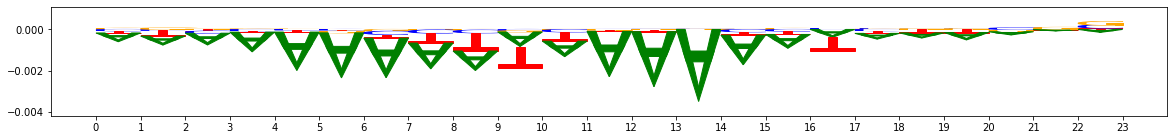

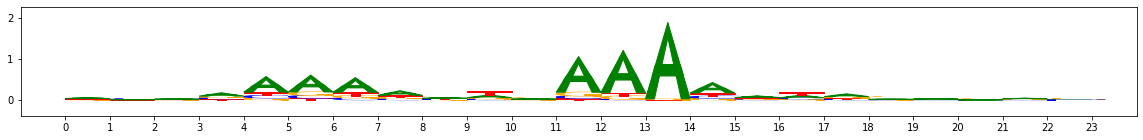

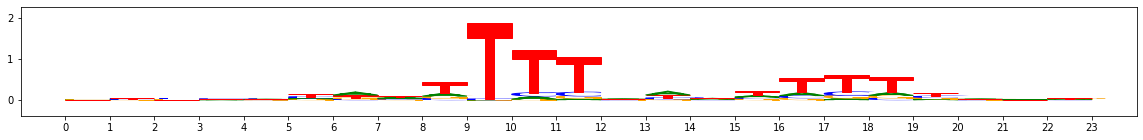

metacluster_1 pattern_4
total seqlets: 88
Task 0 hypothetical scores:


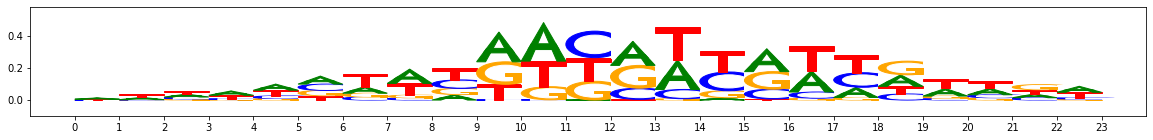

Task 0 actual importance scores:


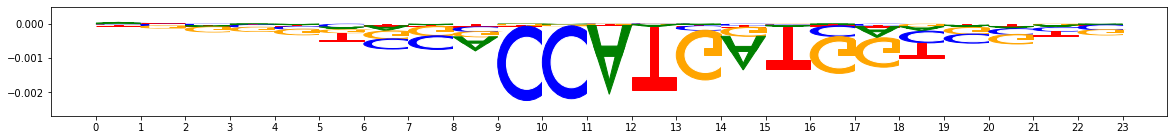

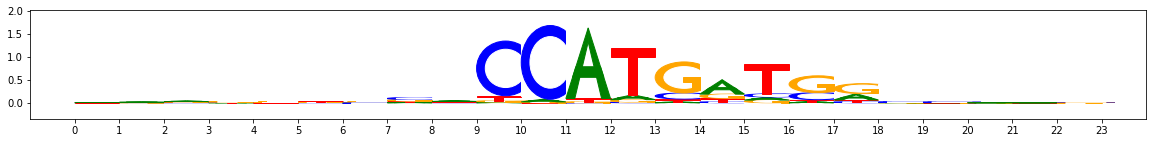

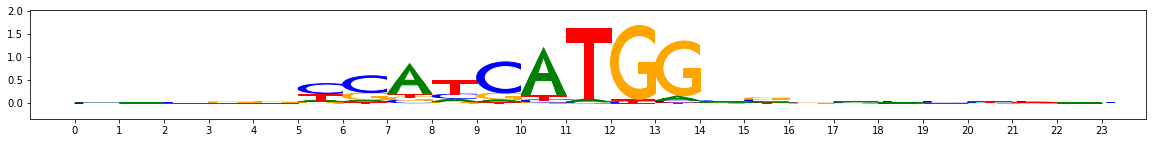

metacluster_1 pattern_5
total seqlets: 86
Task 0 hypothetical scores:


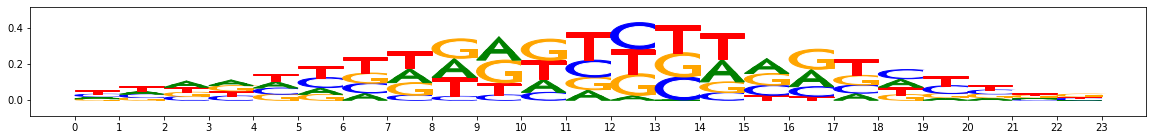

Task 0 actual importance scores:


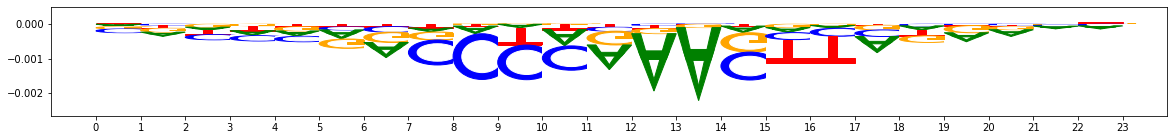

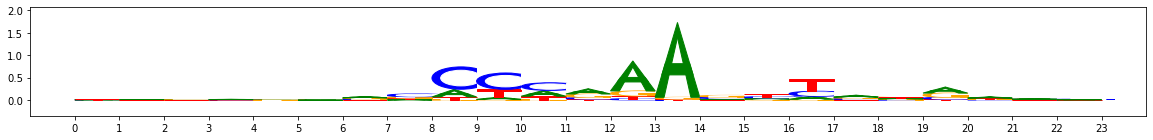

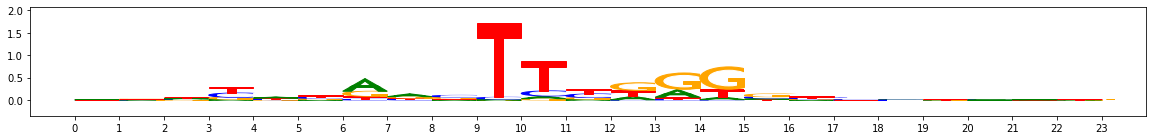

metacluster_1 pattern_6
total seqlets: 85
Task 0 hypothetical scores:


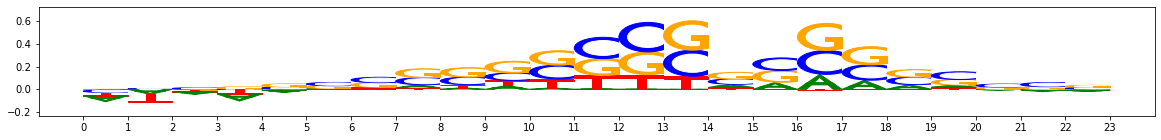

Task 0 actual importance scores:


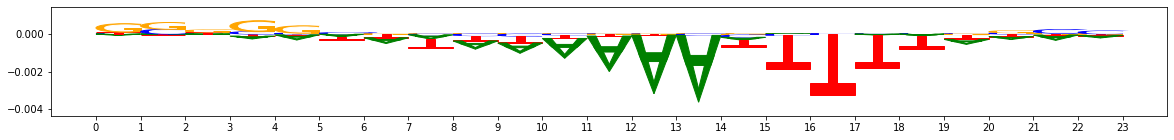

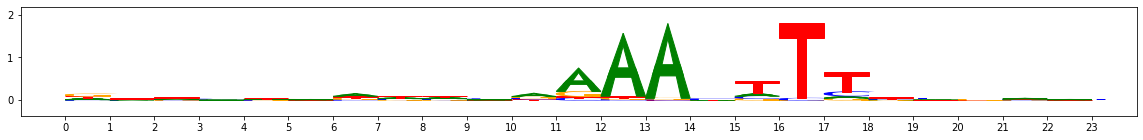

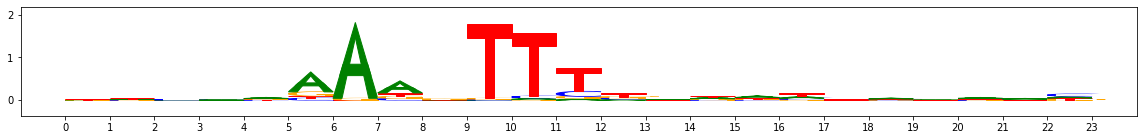

metacluster_1 pattern_7
total seqlets: 77
Task 0 hypothetical scores:


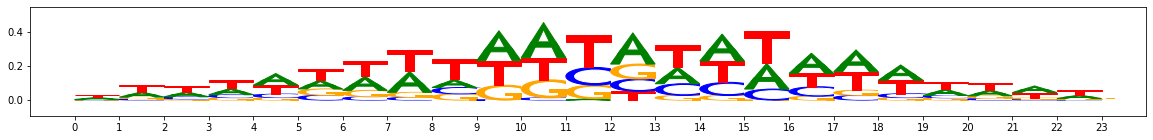

Task 0 actual importance scores:


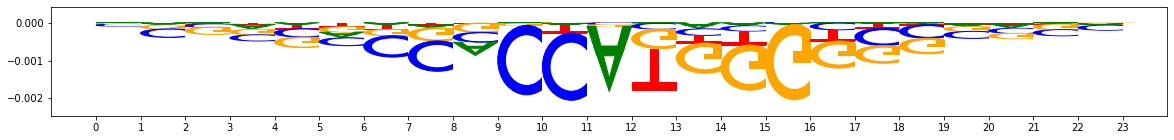

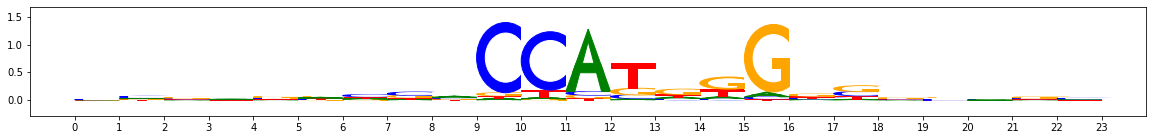

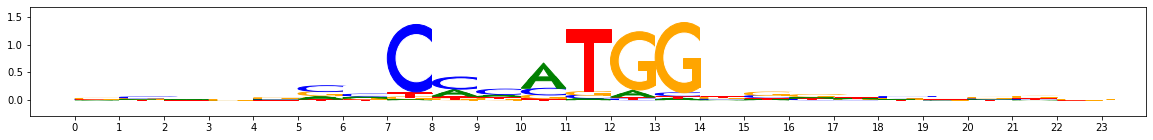

metacluster_1 pattern_8
total seqlets: 69
Task 0 hypothetical scores:


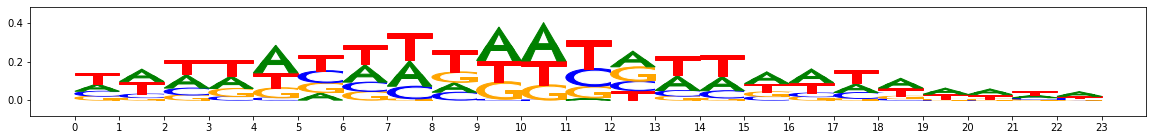

Task 0 actual importance scores:


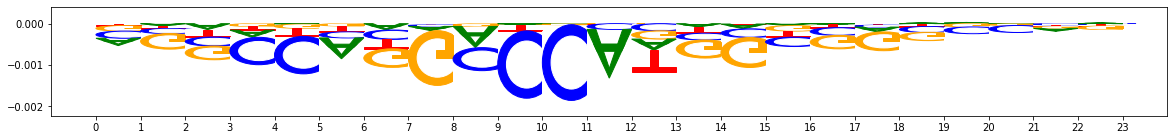

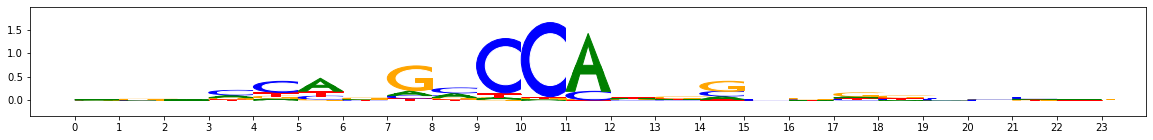

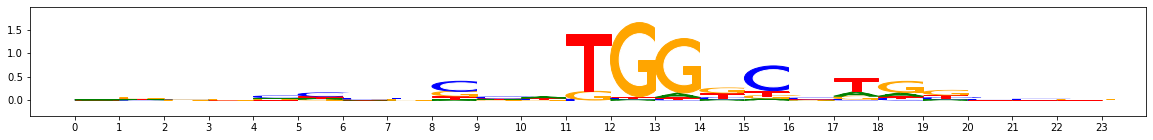

metacluster_1 pattern_9
total seqlets: 67
Task 0 hypothetical scores:


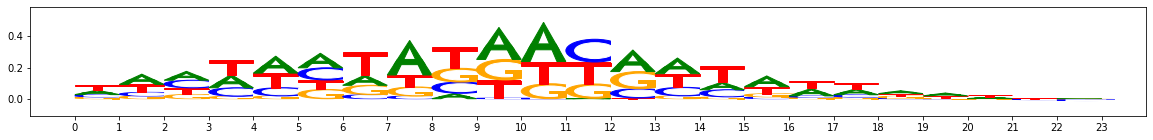

Task 0 actual importance scores:


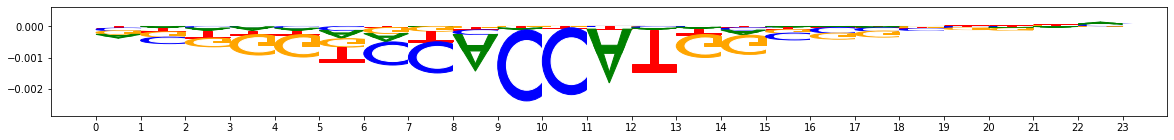

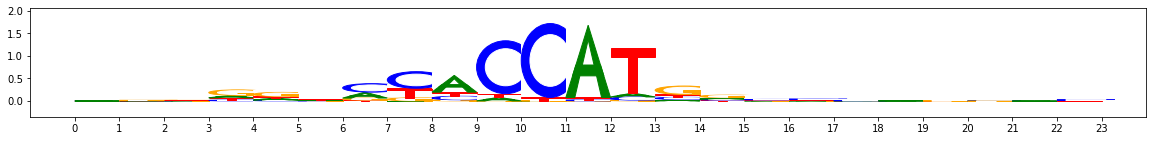

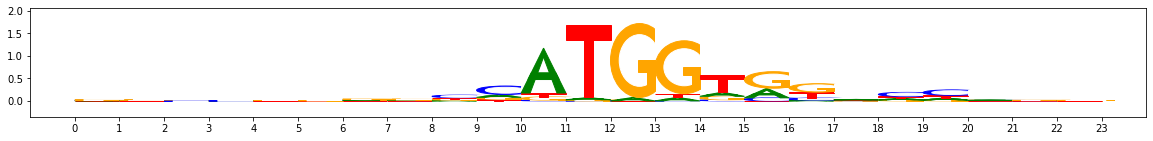

metacluster_1 pattern_10
total seqlets: 59
Task 0 hypothetical scores:


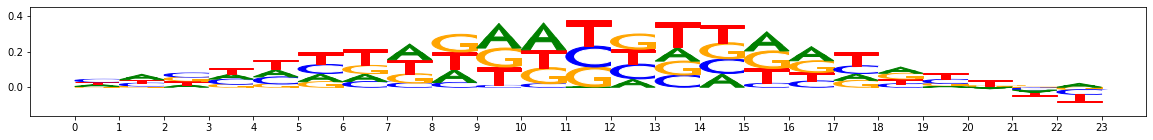

Task 0 actual importance scores:


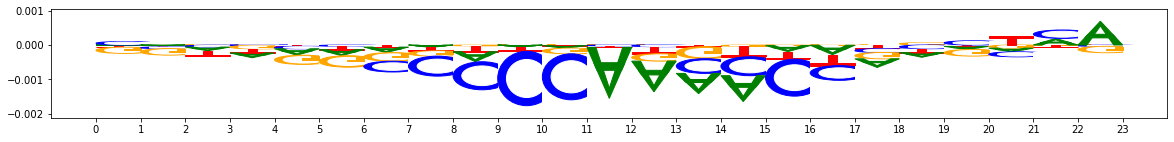

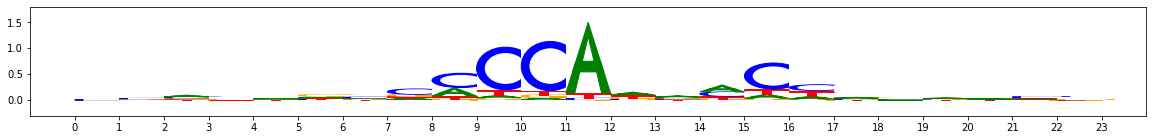

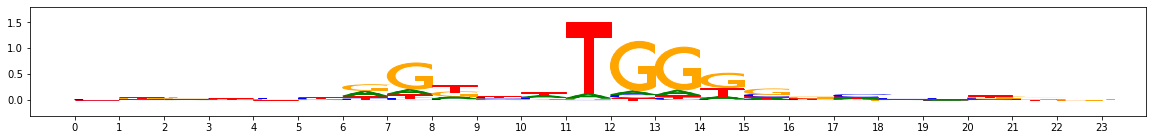

metacluster_1 pattern_11
total seqlets: 53
Task 0 hypothetical scores:


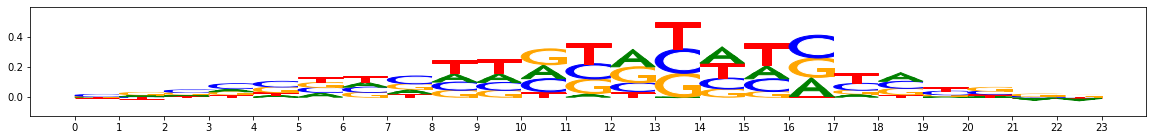

Task 0 actual importance scores:


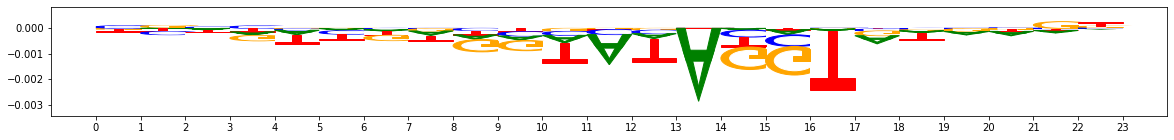

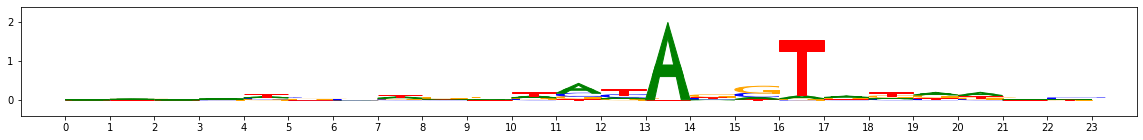

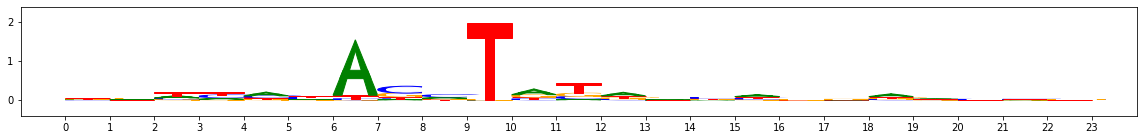

metacluster_1 pattern_12
total seqlets: 40
Task 0 hypothetical scores:


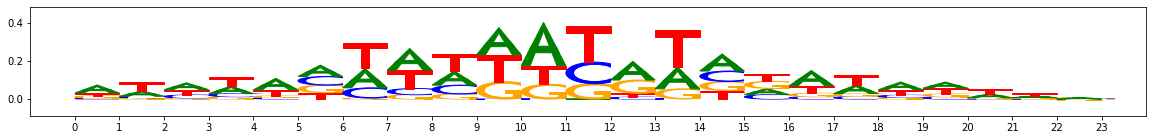

Task 0 actual importance scores:


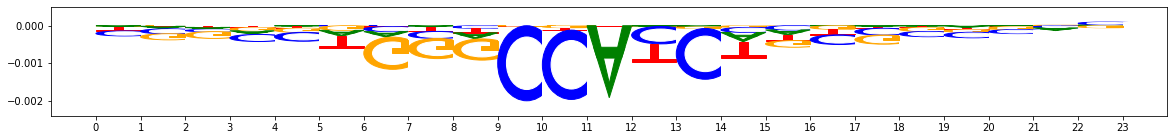

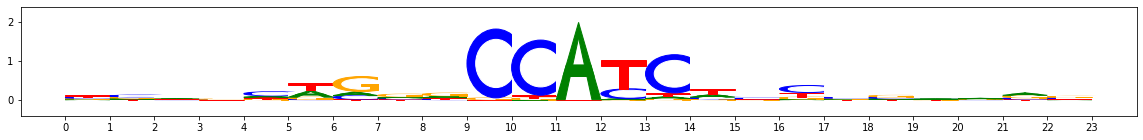

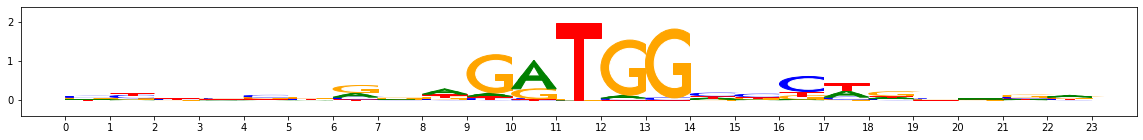

In [2]:
import sys 

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

i = 1
for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    print(len(all_pattern_names))

    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.29, 0.21, 0.21, 0.29])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        try:
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                            background=background)) 
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                            background=background))
        except:
            print("Probabilities do not add up to 1")
        
hdf5_results.close()